## Let's compare methods

In [1]:
import numpy as np
from numpy import linalg as lg

import warnings
warnings.filterwarnings('ignore')

### Для начала реализуем метод Модифицированного Гаусса-Ньютона, Метод трех квадратов и Метод стохастических квадратов.
Реализация в одном классе

In [2]:
class Solution(object):
    """
    search solution in L2 norm
    """
    def resolveByModifiedNewton(self, x0, F, J, L,  eps = 10e-7, needInf = False, maxIter = 1000):
        """
        Inputs:
        x_0 - start point
        F - function
        J - Jacobian
        L - digit that more o equal to Lipschitz constant 
        Returns :
        if needInf = False :
            x - solution of optimization problem
        else :
            x - solution of optimization problem
            iterCount - count of iterations
        
        """
        iterCount = 1
        x =  x0 - lg.inv(J(x0) + L/2*lg.inv(J(x0).T)).dot(F(x0)) ## поиск argmin(psi)
        while lg.norm(x  - x0) > eps and iterCount < maxIter :
            iterCount += 1
            x0 = x
            x = x0 - lg.inv(J(x0) + L/2*lg.inv(J(x0).T)).dot(F(x0))  ## поиск argmin(psi)
        if needInf:
            return x, iterCount
        return x
    
    def resolveByThreeSquares(self,x_0 , F, J, L, eps = 10e-7, needInf = False, maxIter = 1000):
        """
        Inputs:
        x_0 - start point
        F - function
        J - Jacobian
        L - digit that more o equal to Lipschitz constant 
        Returns :
        if needInf = False :
            x - solution of optimization problem
        else :
            x - solution of optimization problem
            iterCount - count of iterations
        """
        iterCount = 1
        x = x_0 - lg.inv(J(x_0) + L*lg.norm(F(x_0))*lg.inv(J(x_0).T)).dot(F(x_0))  ## поиск argmin(fi)
        while lg.norm(x  - x_0) > eps and iterCount < maxIter : 
            iterCount += 1
            x_0 = x
            x = x_0 - lg.inv(J(x_0) + L*lg.norm(F(x_0))*lg.inv(J(x_0).T)).dot(F(x_0))## поиск argmin(fi)
        if needInf:
            return x, iterCount
        return x
              
        
    def resolveByStochasticSquares(self, x_0 , F, J, L, p, eps = 10e-7, needInf = False, maxIter = 1000):
        """
        Inputs:
        x_0 - start point
        F - function
        J - Jacobian
        L - digit that more o equal to Lipschitz constant 
        p - constant for Stochastic Squares
        Returns :
        if needInf = False :
            x - solution of optimization problem
        else :
            x - solution of optimization problem
            iterCount - count of iterations
            
        We consider F: R^n -> R^n
        """
        n = len(x_0)
        m = n
        I = range(1, p + 1)
        x = x_0
        k = 0
        
        while (lg.norm(x  - x_0) > eps and k < maxIter) or (k == 0) : 
            k += 1
            x_p = x[:p]
            G = J(x)[:][:p].T
            i = 0
            T = np.inf*np.ones(n)
            while (i == 0) or (lg.norm(F(T))/m > lg.norm(F(T))/m + sum(F(x).dot(J(x)) * (T - x))  + m/(2*p*lg.norm(F(x))) * lg.norm(G.T.dot(T - x)) + 2**(i - 1)*L*lg.norm(T - x)**2):
                i += 1
                I = np.eye(n)
                Ip = np.eye(p)
                gamma = m/(2**(i+1)*p*L*lg.norm(x))
                B = 1/(2**i*L)*(I - gamma*G.dot(lg.inv(Ip + gamma*G.T.dot(G)).dot(G.T)))
                T = F(x).dot(J(x)).dot(B)/lg.norm(F(x))
            
            x_0 = x
            x = T
            L = 2**(i-1)*L
        
        if needInf:
            return x, k
        return x
            
        

## Реализуем функции, на которых будем тестировать

In [3]:
# Чебышев осциллятор и его Якобиан
def J1(x):
    J = np.zeros((len(x), len(x)))
    J[0][0] =1
    for i in range(1,len(x)):
        J[i][i] = 1
        J[i][i-1] = 4*x[i-1]
    return J

def F1(x):
    F = np.zeros(len(x))
    F[0] = x[0] - 1
    for i in range(1,len(x)):
        F[i] = x[i] - 2*x[i-1]**2 + 1
    return F
        
# Тригонометрический осциллятор и его Якобиан

def J2(x):
    J = np.zeros((len(x), len(x)))
    J[0][0] =1
    for i in range(1,len(x)):
        J[i][i] = 1
        J[i][i-1] = np.pi*2*np.sin(x[i-1])*np.cos(x[i-1])
    return J     


def F2(x):
    F = np.zeros(len(x))
    F[0] = x[0] - 1
    for i in range(1,len(x)):
        F[i] = x[i] - 2*np.sin(np.pi*x[i-1]/2)**2 + 1
    return F

# Функция F(x) = x и ее Якобиан

def F3(x):
    return x

def J3(x):
    J = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        J[i][i] = 2* x[i]
    return J

### Function for plot

In [4]:
import matplotlib.pyplot as plt
def printPlot(maxSTEP, iterN, iterT, timeN, timeT):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    
    ax1.plot(range(1,maxSTEP), iterN, 'rx', range(1,maxSTEP), iterT, 'b+', linestyle='solid')
    lgnd = ax1.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
    ax1.set_xlabel('n')
    ax1.set_title('iterations')
    
    ax2 = plt.gca()
    ax2.plot(range(1,maxSTEP), timeN, 'rx', range(1,maxSTEP), timeT, 'b+', linestyle='solid')
    lgnd = ax2.legend(['Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
    ax2.set_xlabel('n')
    ax2.set_title('time')
    f.set_size_inches(10, 4)
    plt.show()

## Функция для сравнения метода трех квадратов и модифицир. метода Г-Н

In [5]:
import time

def Testing(F, J, L = 90, getX = None, maxSTEP = 11):
    """
        Inputs:
        F - function
        J - Jacobian
        L - digit that more o equal to Lipschitz constant 
        getX -  the function receives the input number n and returns the starting point
                for the n'th dimension. By default, the point is taken (-1, 1, ...., 1)
        Returns :
        plot grafics with iteretions and time dependence
        
    """
    sol = Solution()
   
    AveragetimeN = np.zeros(maxSTEP - 1)
    AveragetimeT = np.zeros(maxSTEP - 1)
    AverageiterT = np.zeros(maxSTEP - 1)
    AverageiterN = np.zeros(maxSTEP - 1)
    

    
        
    timeN = []
    timeT = []
    iterT = []
    iterN = []
        
    for i in range(1,maxSTEP):
            
        if(getX):
            x_0 = getX(i)
        else:
            x_0 = np.ones(i)
            x_0[0] = -1
        t = time.clock()
        x_n, it = sol.resolveByModifiedNewton(x_0,F, J, L, eps = 10e-3, needInf = True )
        timeN += [time.clock() - t]
        iterN += [it]
            
        #print("timeN : " + str(timeN[-1]) + "  iterN : " + str(iterN[-1]))
            
        t = time.clock()
        x_t, it = sol.resolveByThreeSquares(x_0,F, J, L, eps = 10e-3, needInf = True)
        timeT += [time.clock() - t]
        iterT += [it]
        #print("Three Squar " +  str(x_t))
        #print("timeT : " + str(timeT[-1]) + "  iterT : " + str(iterT[-1]))
            

    AveragetimeN += np.array(timeN)
    AveragetimeT += np.array(timeT)
    AverageiterT += np.array(iterT)
    AverageiterN += np.array(iterN)
    
    timeN = AveragetimeN
    timeT = AveragetimeT
    iterT = AverageiterT
    iterN = AverageiterN
    
    printPlot(maxSTEP, iterN, iterT, timeN, timeT) 
    
    
    
    



### Сравнение метода трех квадратов и модиф Г-Н

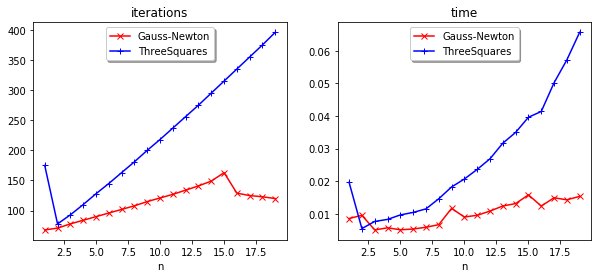

In [6]:
### Testing F1
Testing(F1, J1,  maxSTEP = 20)

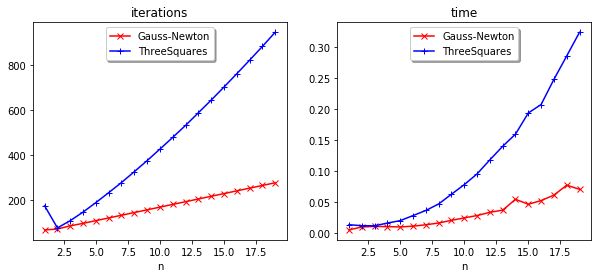

In [7]:
### Testing F2
Testing(F2, J2, maxSTEP = 20)

In [8]:
def getX(i):
    x = np.ones(i)
    return x*0.5

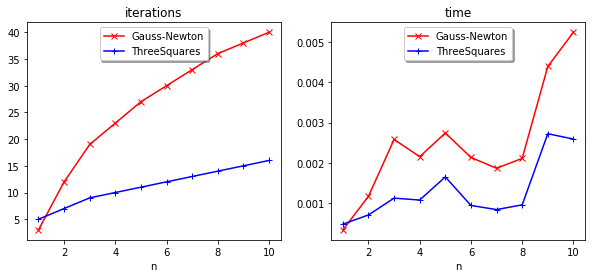

In [9]:
### Test F3
Testing(F3, J3, getX = getX)

## Функция для сравнения Стохастич.метода с остальными методами


т.к мне интересно поведение Стохастического метода в зависимости от p, то я фиксирую размерность пространства, поэтому графики методов 
Г-Н и трех квадратов будут прямыми, параллельными оси OX.

In [10]:
import time

def TestingStochasticSquares(F, J, n = 10, L = 1, getX = None):
    """
     Inputs:
        F - function
        J - Jacobian
        L - digit that more o equal to Lipschitz constant 
        n - dimension space
        getX -  the function receives the input number n and returns the starting point
                for the n'th dimension. By default, the point is taken (-1, 1, ...., 1)
    Returns :
    plot grafics with iteretions and time dependence
    """
    sol = Solution()
   

        
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    
    
    
    time_Stoch = []
    iteration = []
        
    if(getX):
        x_0 = getX(n)
    else:
        x_0 = np.ones(n)
        x_0[0] = -1
        
    for p in range(1, n ):    
        t = time.clock()
        x_n, it = sol.resolveByStochasticSquares(x_0,F, J, L, p,eps = 10e-8, needInf = True )
        #print("p : " + str(x_n))
        time_Stoch += [time.clock() - t]
        iteration += [it]
    
    t = time.clock()
    x_N, iter_N = sol.resolveByModifiedNewton(x_0,F, J, L = 90, eps = 10e-3, needInf = True )
    time_N = time.clock() - t
    
    t = time.clock()
    x_S, iter_S = sol.resolveByThreeSquares(x_0,F, J, L = 90, eps = 10e-3, needInf = True )
    time_S = time.clock() - t
        
    ax1.plot(range(1,n), iteration, 'bx', range(1,n), [iter_N]*(n-1) , 'r+', range(1,n), [iter_S]*(n-1), 'rx' , linestyle='solid')
    ax2.plot(range(1,n), time_Stoch, 'bx', range(1,n), [time_N]*(n-1) , 'r+', range(1,n), [time_S]*(n-1), 'rx' , linestyle='solid')

    lgnd = ax1.legend(['StochasticSquares','Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
    ax1.set_xlabel('p')
    ax1.set_title('iterations')  

    
    #ax2 = plt.gca()
    lgnd = ax2.legend(['StochasticSquares','Gauss-Newton', 'ThreeSquares'], loc='upper center', shadow=True)
    ax2.set_xlabel('p')
    ax2.set_title('time')
    
    f.set_size_inches(10, 4)
    plt.show()
    
    

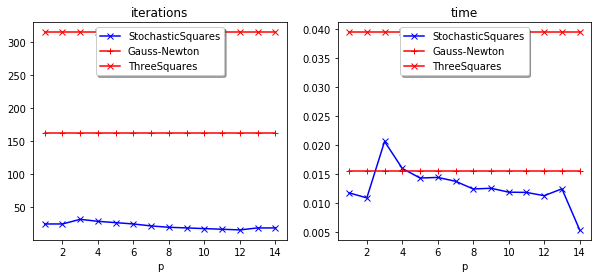

In [11]:
# Для функции F1

TestingStochasticSquares(F1, J1, n = 15)

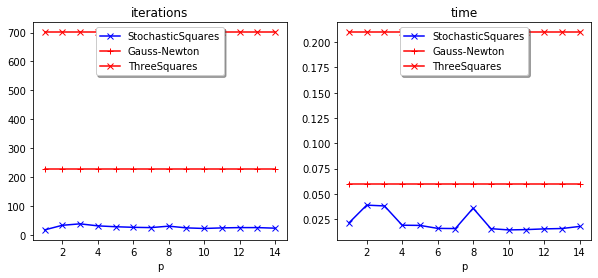

In [12]:
#для функции F2

TestingStochasticSquares(F2, J2, n = 15)

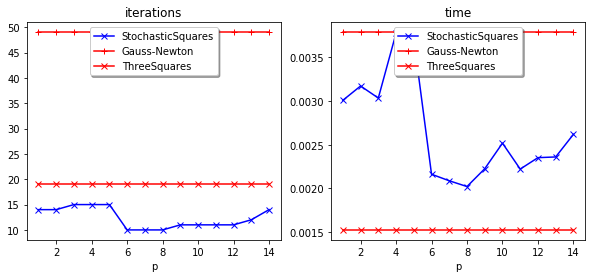

In [13]:
# для функции F3

TestingStochasticSquares(F3, J3, getX = getX, n = 15)